In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


In [2]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

train['주택소유상태'].value_counts()

MORTGAGE    47934
RENT        37705
OWN         10654
ANY             1
Name: 주택소유상태, dtype: int64

In [7]:
def basic_data_processing():
    train = pd.read_csv('./open/train.csv')
    test = pd.read_csv('./open/test.csv')
    train['대출기간'] = train['대출기간'].apply(lambda x:x[:3])
    train['대출기간'] = train['대출기간'].astype('int64')
    test['대출기간'] = test['대출기간'].apply(lambda x:x[:3])
    test['대출기간'] = test['대출기간'].astype('int64')

    trans = {'1 year':1,
     '1 years':1,
     '10+ years':12,
     '10+years':12,
     '2 years':2,
     '3':3,
     '3 years':3,
     '4 years':4,
     '5 years':5,
     '6 years':6,
     '7 years':7,
     '8 years':8,
     '9 years':9,
     '< 1 year':0.5,
     '<1 year':0.5,
     'Unknown':0}

    train['근로기간'] = [trans[i] for i in train['근로기간'].values]
    test['근로기간'] = [trans[i] for i in test['근로기간'].values]
#     train.loc[train[train['부채_대비_소득_비율'] == 9999].index,'부채_대비_소득_비율'] = 2000
#     test.loc[test[test['부채_대비_소득_비율'] == 9999].index,'부채_대비_소득_비율'] = 2000
    train = train.drop(train[train['주택소유상태']=='ANY'].index)

    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()
    ordinal = OrdinalEncoder()

    for tt in ['주택소유상태','대출목적']:
        train[tt] = ordinal.fit_transform(train[[tt]])
        test[tt] = ordinal.fit_transform(test[[tt]])

    train = train.drop('ID',axis=1)
    test = test.drop('ID',axis=1)
    train = train.reset_index(drop=True)

    target = ['A','B','C','D','E','F','G']
    ordinal_mapping = {target[i]:i for i in range(len(target))}
    train['대출등급'] = train['대출등급'].map(ordinal_mapping)

    train.columns = ['loan_amount', 'loan_term', 'employment_duration', 'home_ownership_status', 
     'annual_income', 'debt_to_income_ratio', 'total_accounts', 'loan_purpose', 
     'recent_2_years_delinquency_count', 'total_principal_repaid', 'total_interest_repaid', 
     'total_overdue_amount', 'number_of_delinquent_accounts', 'loan_grade']
    test.columns = ['loan_amount', 'loan_term', 'employment_duration', 'home_ownership_status', 
     'annual_income', 'debt_to_income_ratio', 'total_accounts', 'loan_purpose', 
     'recent_2_years_delinquency_count', 'total_principal_repaid', 'total_interest_repaid', 
     'total_overdue_amount', 'number_of_delinquent_accounts']
    droping = ['recent_2_years_delinquency_count', 'home_ownership_status', 'number_of_delinquent_accounts']
    train = train.drop(droping,axis=1)
    test = test.drop(droping,axis=1)
    train['sudo1'] = pd.qcut(train['annual_income'], q=7, labels=False)
    test['sudo1'] = pd.qcut(test['annual_income'], q=7, labels=False)
    train['sudo2'] = pd.qcut(train['loan_amount'], q=7, labels=False)
    test['sudo2'] = pd.qcut(test['loan_amount'], q=7, labels=False)
    train['sudo3'] = pd.qcut(train['total_principal_repaid'], q=7, labels=False)
    test['sudo3'] = pd.qcut(test['total_principal_repaid'], q=7, labels=False)
    train['sudo3'] = pd.qcut(train['total_interest_repaid'], q=7, labels=False)
    test['sudo3'] = pd.qcut(test['total_interest_repaid'], q=7, labels=False)

    return train, test

In [4]:
train,test = basic_data_processing()

In [5]:
train

,loan_amount,loan_term,employment_duration,home_ownership_status,annual_income,debt_to_income_ratio,total_accounts,loan_purpose,recent_2_years_delinquency_count,total_principal_repaid,total_interest_repaid,total_overdue_amount,number_of_delinquent_accounts,loan_grade,sudo1,sudo2,sudo3
0,12480000,36,6.0,2.0,72000000,18.90,15,1.0,0,0,0.0,0.0,0.0,2,2,2,0
1,14400000,60,12.0,0.0,130800000,22.33,21,10.0,0,373572,234060.0,0.0,0.0,1,5,2,2
2,12000000,36,5.0,0.0,96000000,8.60,14,1.0,0,928644,151944.0,0.0,0.0,0,4,2,1
3,14400000,36,8.0,0.0,132000000,15.09,15,1.0,0,325824,153108.0,0.0,0.0,2,5,2,1
4,18000000,60,0.0,2.0,71736000,25.39,19,8.0,0,228540,148956.0,0.0,0.0,1,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96288,14400000,36,12.0,0.0,210000000,9.33,33,3.0,0,974580,492168.0,0.0,0.0,2,6,2,4
96289,28800000,60,12.0,0.0,132000000,5.16,25,10.0,0,583728,855084.0,0.0,0.0,4,5,5,6
96290,14400000,36,1.0,0.0,84000000,11.24,22,3.0,0,1489128,241236.0,0.0,0.0,0,3,2,3
96291,15600000,36,5.0,0.0,66330000,17.30,21,1.0,2,1378368,818076.0,0.0,0.0,3,2,3,5


In [6]:
test.describe()

,loan_amount,loan_term,employment_duration,home_ownership_status,annual_income,debt_to_income_ratio,total_accounts,loan_purpose,recent_2_years_delinquency_count,total_principal_repaid,total_interest_repaid,total_overdue_amount,number_of_delinquent_accounts,sudo1,sudo2,sudo3
count,6.419700e+04,64197.000000,64197.000000,64197.000000,6.419700e+04,64197.000000,64197.000000,64197.000000,64197.000000,6.419700e+04,6.419700e+04,64197.000000,64197.000000,64197.000000,64197.000000,64197.000000
mean,1.829630e+07,43.838871,6.355795,0.899403,9.446378e+07,19.433747,25.295310,3.333458,0.342882,8.231412e+05,4.324562e+05,50.313192,0.005499,2.964422,2.891615,2.999455
std,1.038592e+07,11.255531,4.619138,0.937069,1.117071e+08,40.375816,12.021127,2.522497,0.901277,9.880161e+05,4.472797e+05,1396.384546,0.080020,2.012473,1.980652,2.000128
min,1.200000e+06,36.000000,0.000000,0.000000,0.000000e+00,0.000000,4.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.008000e+07,36.000000,2.000000,0.000000,5.759880e+07,12.630000,17.000000,2.000000,0.000000,3.081840e+05,1.343520e+05,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.680000e+07,36.000000,6.000000,1.000000,7.800000e+07,18.770000,24.000000,2.000000,0.000000,5.986800e+05,2.875680e+05,0.000000,0.000000,3.000000,3.000000,3.000000
75%,2.400000e+07,60.000000,12.000000,2.000000,1.128000e+08,25.560000,32.000000,4.000000,0.000000,1.061508e+06,5.774160e+05,0.000000,0.000000,5.000000,4.000000,5.000000
max,4.200000e+07,60.000000,12.000000,2.000000,1.044790e+10,9999.000000,135.000000,12.000000,15.000000,4.049760e+07,5.645688e+06,108240.000000,4.000000,6.000000,6.000000,6.000000


In [338]:
test[(test['annual_income'] < 2*10**7) & (train['employment_duration'] > 1)]['employment_duration'].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_8664\1555409858.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test[(test['annual_income'] < 2*10**7) & (train['employment_duration'] > 1)]['employment_duration'].value_counts()


0.0     179
0.5      36
1.0      24
12.0     14
3.0      12
4.0      12
2.0      10
6.0       8
7.0       6
5.0       6
8.0       6
9.0       4
Name: employment_duration, dtype: int64

<Axes: >

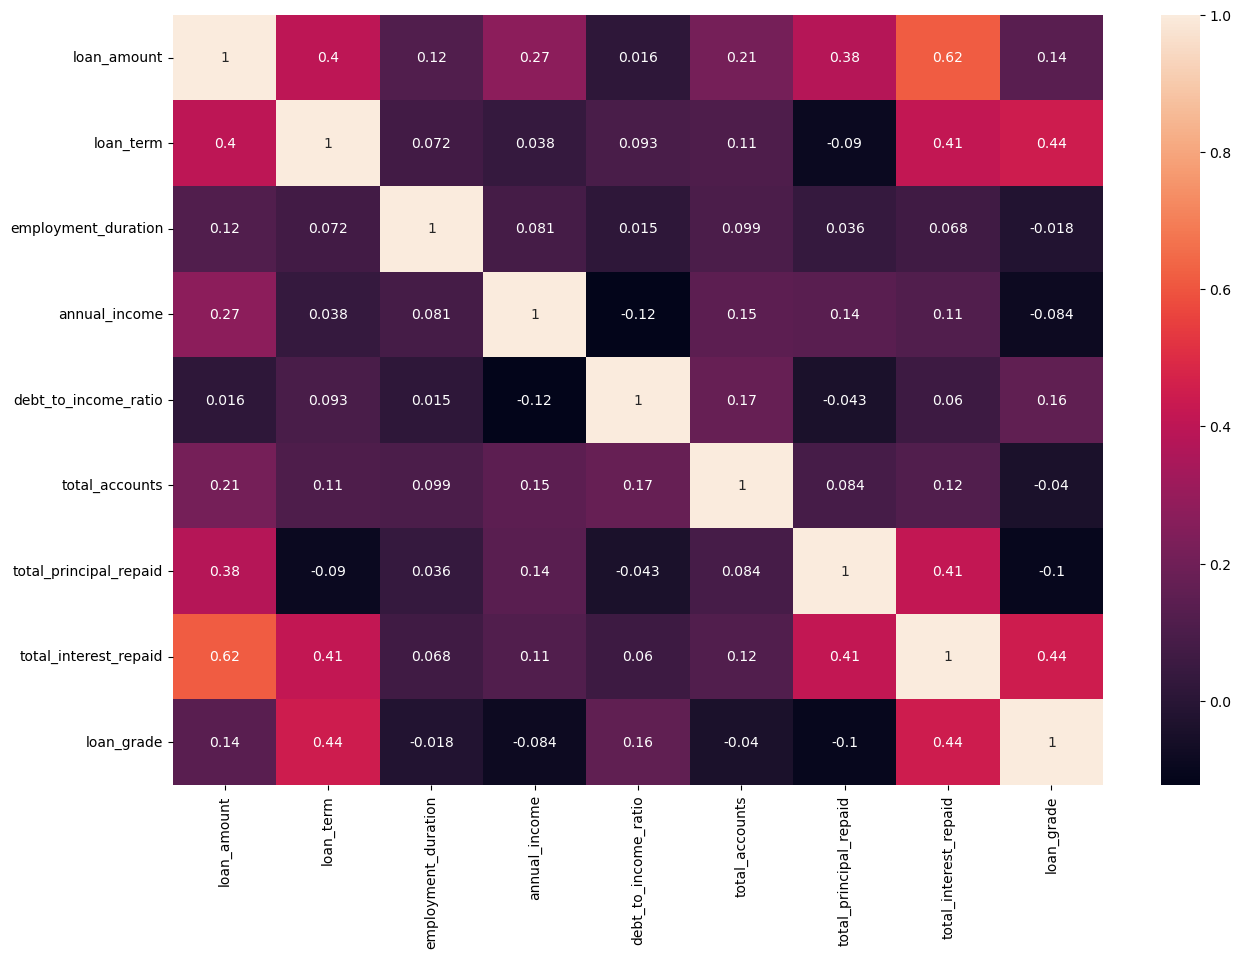

In [320]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),annot=True)

In [273]:
# from pycaret.classification import *
# target = 'loan_grade'
# X = train.drop(target,axis=1)
# y = train[[target]]
# test_ratio = 0.2
# cut_ratio = 0.1


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=test_ratio, stratify=y, random_state=42
# )

# # PyCaret에서 사용할 데이터 프레임 생성 (실제 데이터에 맞게 설정 필요)
# data = pd.concat([X_train, y_train], axis=1)

# # PyCaret의 setup 함수를 사용하여 실험 환경 설정
# exp1 = setup(data, target='loan_grade', fold=10, session_id=42)

# # 모델 비교
# best_model = compare_models(sort='F1', fold=10) # , include=['lightgbm', 'xgboost', 'catboost'])

# # best_model로 훈련
# final_model = finalize_model(best_model)

# # 테스트 데이터에 대한 예측
# predictions = predict_model(final_model, data=X_test)

# # Macro F1 Score 출력
# macro_f1_score = f1_score(y_test, predictions['predction_label'], average='macro')
# print(f"Macro F1 Score on Test Data: {macro_f1_score:.4f}")


In [316]:
# # AB/CDE/FG
# # ABC/D/EFG
# train, test = basic_data_processing()
# train['sudo1'] = [0 for _ in range(len(train))]
# train['sudo2'] = [0 for _ in range(len(train))]
# for i in range(len(train)):
#     target = train.loc[i,'loan_grade']
#     if target in [0,1]:
#         train.loc[i,'sudo1'] = 0
#         train.loc[i,'sudo2'] = 0
#     elif target == 2:
#         train.loc[i,'sudo1'] = 1
#         train.loc[i,'sudo2'] = 0
#     elif target == 3:
#         train.loc[i,'sudo1'] = 1
#         train.loc[i,'sudo2'] = 1
#     elif target == 4:
#         train.loc[i,'sudo1'] = 1
#         train.loc[i,'sudo2'] = 2
#     else:
#         train.loc[i,'sudo1'] = 2
#         train.loc[i,'sudo2'] = 2
# train



,loan_amount,loan_term,employment_duration,home_ownership_status,annual_income,debt_to_income_ratio,total_accounts,recent_2_years_delinquency_count,total_principal_repaid,total_interest_repaid,total_overdue_amount,number_of_delinquent_accounts,loan_grade,sudo1,sudo2
0,12480000,36,6.0,2.0,72000000,18.90,15,0,0,0.0,0.0,0.0,2,1,0
1,14400000,60,12.0,0.0,130800000,22.33,21,0,373572,234060.0,0.0,0.0,1,0,0
2,12000000,36,5.0,0.0,96000000,8.60,14,0,928644,151944.0,0.0,0.0,0,0,0
3,14400000,36,8.0,0.0,132000000,15.09,15,0,325824,153108.0,0.0,0.0,2,1,0
4,18000000,60,0.0,2.0,71736000,25.39,19,0,228540,148956.0,0.0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96288,14400000,36,12.0,0.0,210000000,9.33,33,0,974580,492168.0,0.0,0.0,2,1,0
96289,28800000,60,12.0,0.0,132000000,5.16,25,0,583728,855084.0,0.0,0.0,4,1,2
96290,14400000,36,1.0,0.0,84000000,11.24,22,0,1489128,241236.0,0.0,0.0,0,0,0
96291,15600000,36,5.0,0.0,66330000,17.30,21,2,1378368,818076.0,0.0,0.0,3,1,1


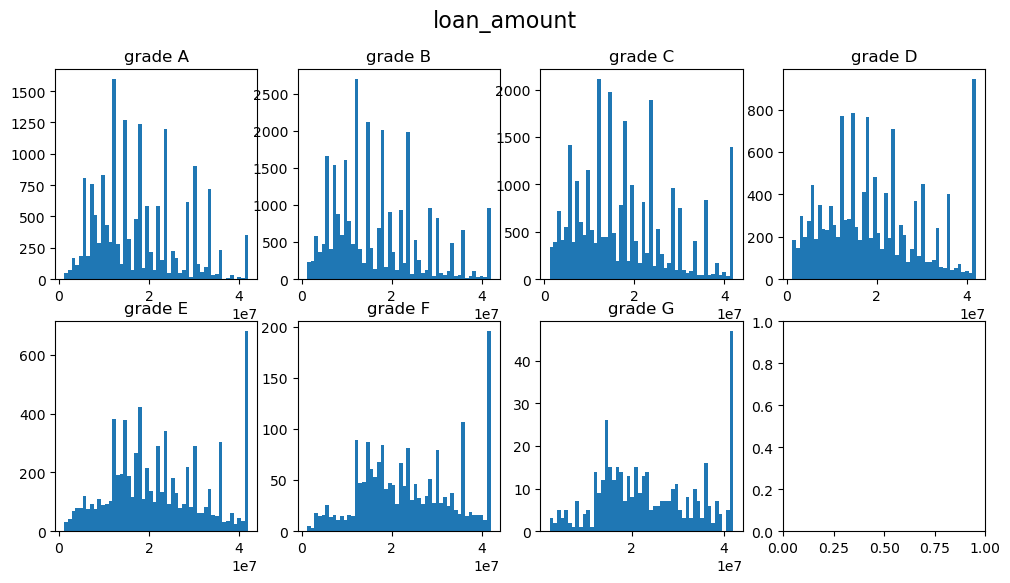

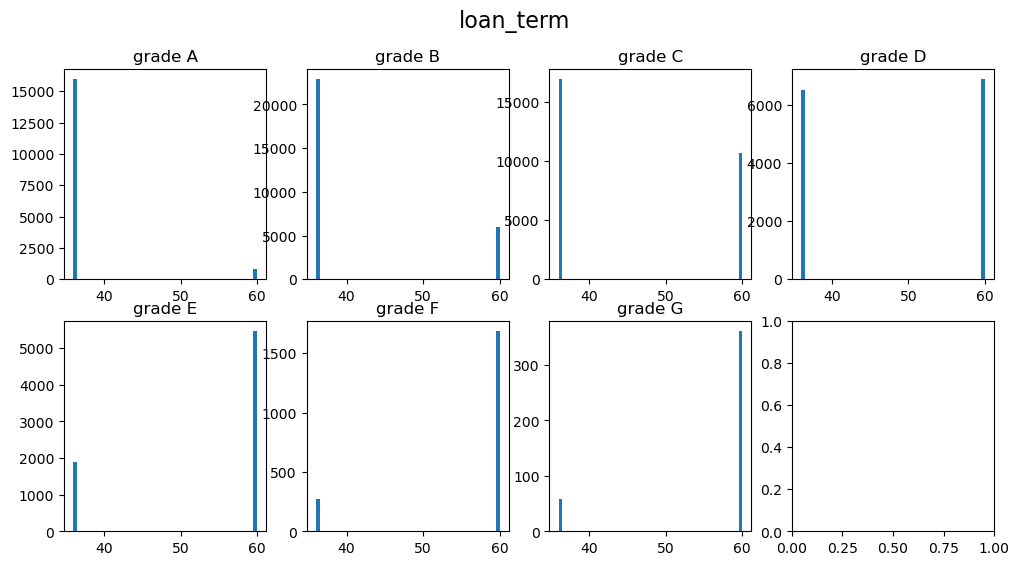

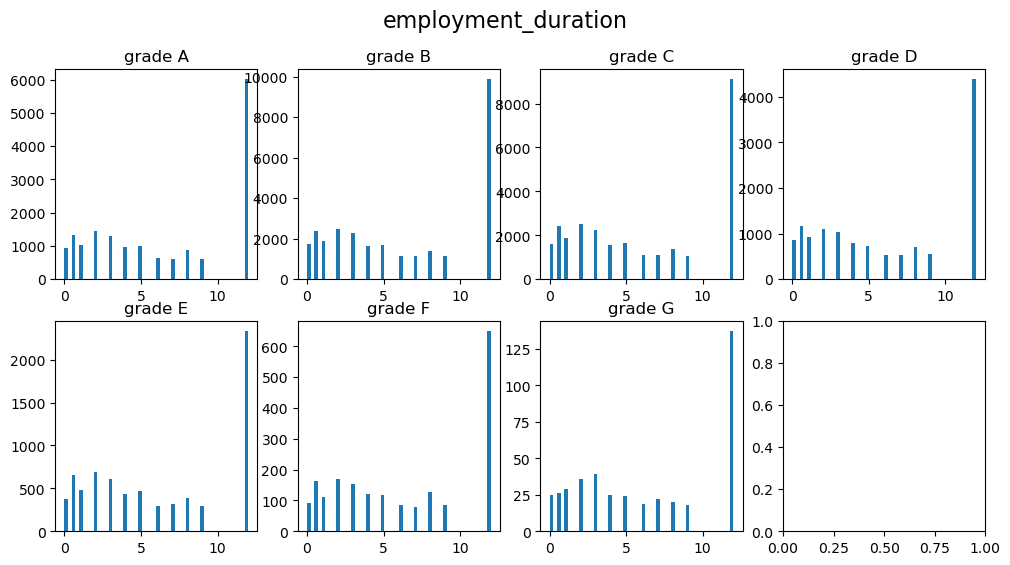

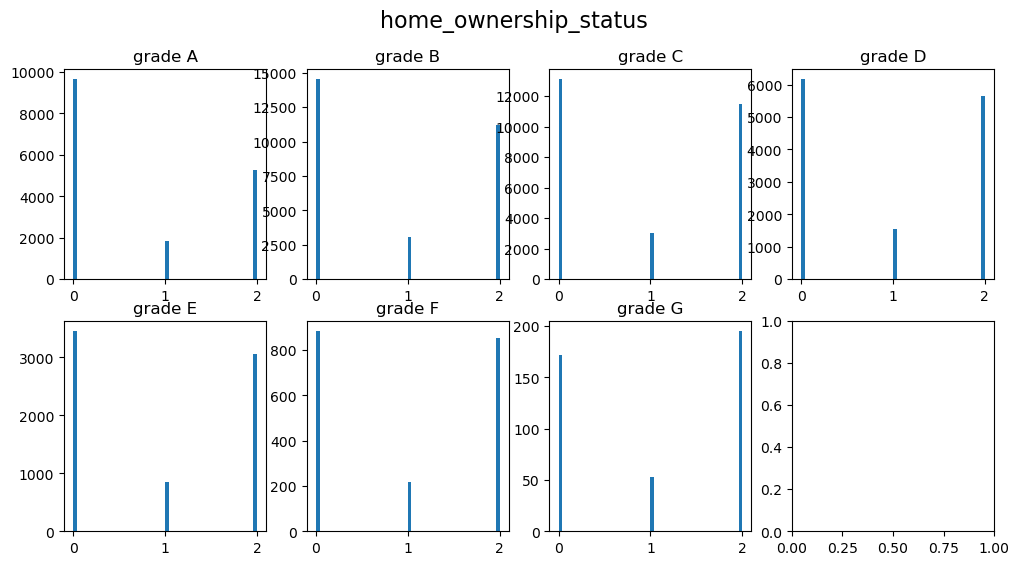

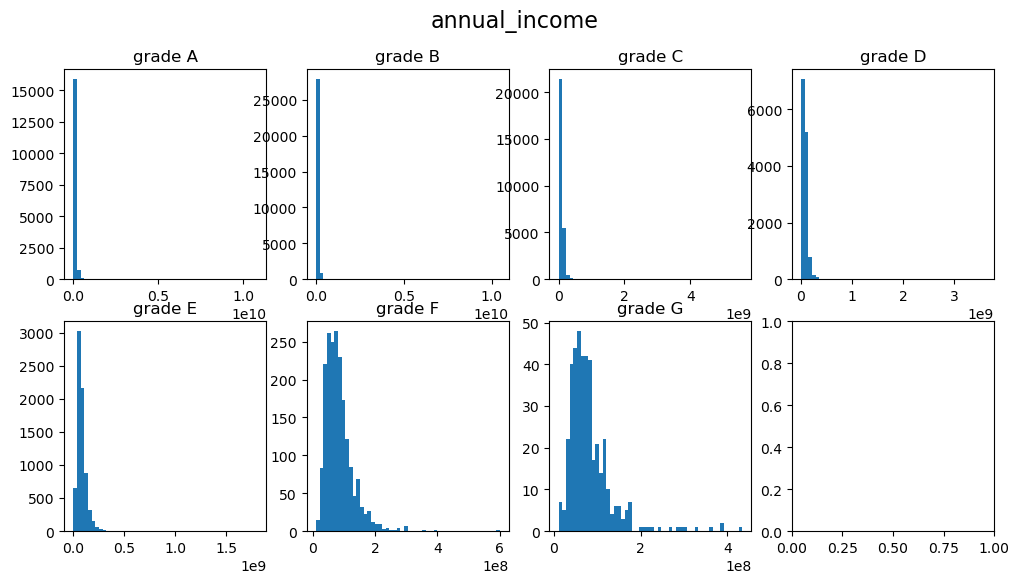

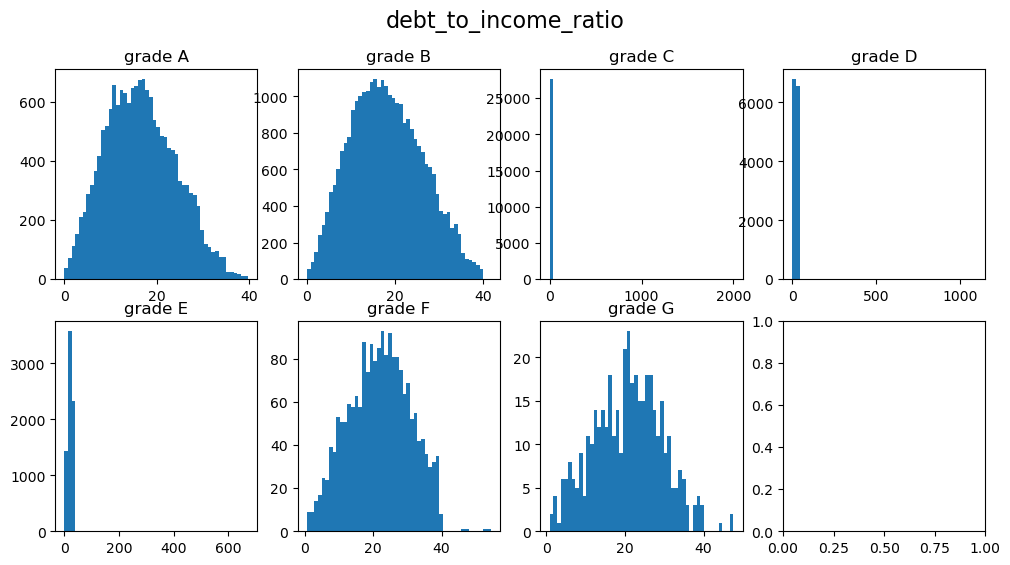

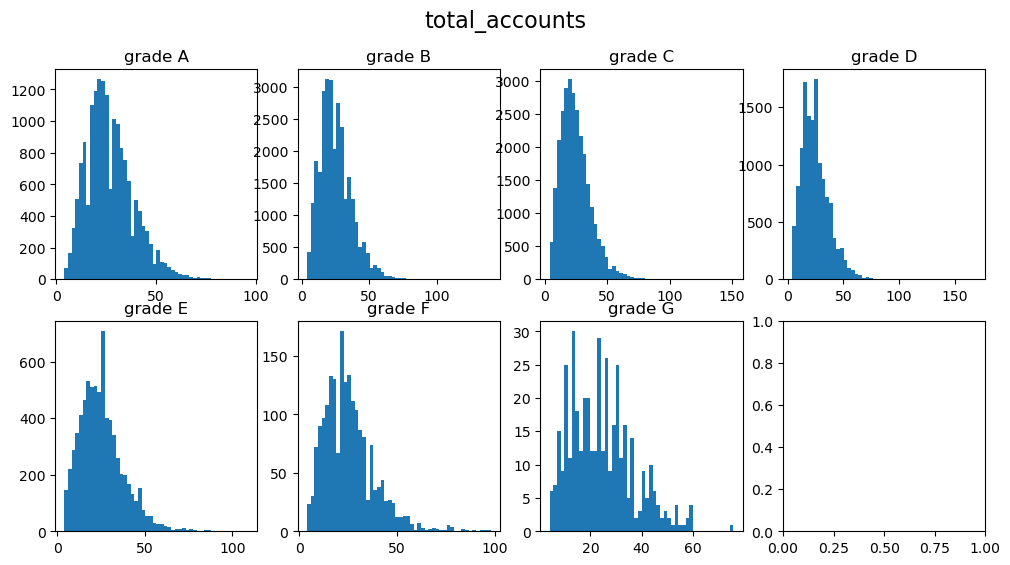

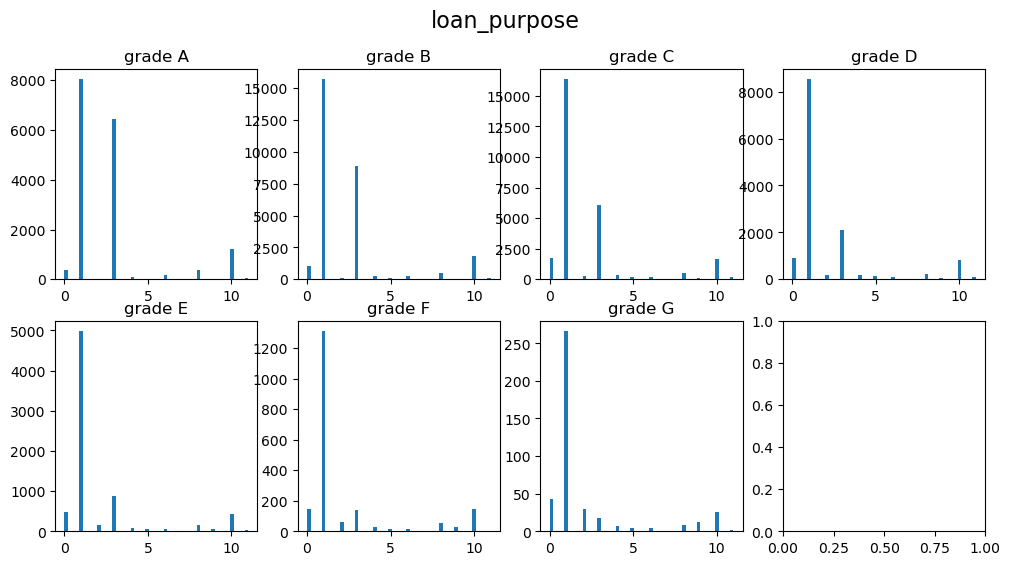

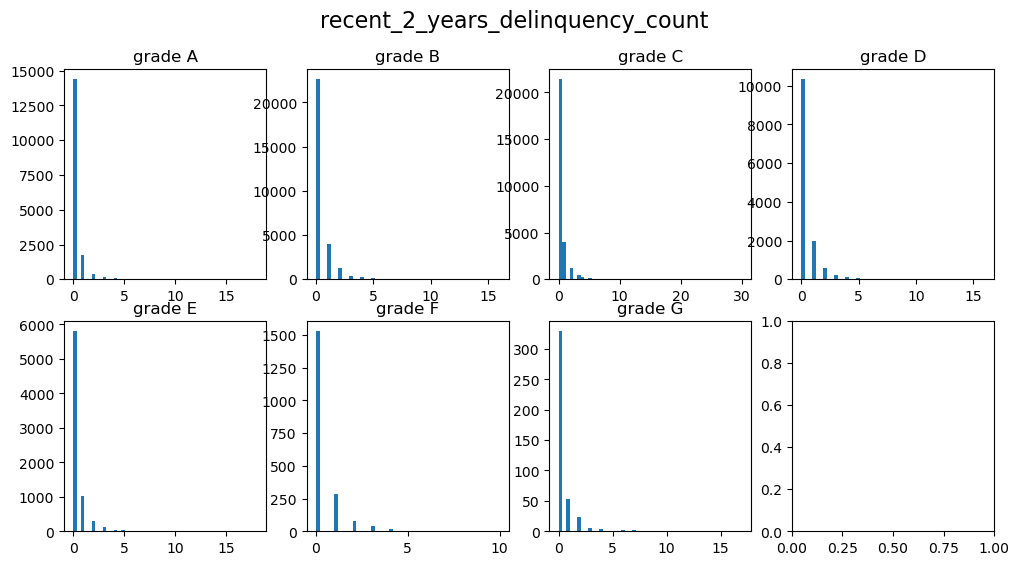

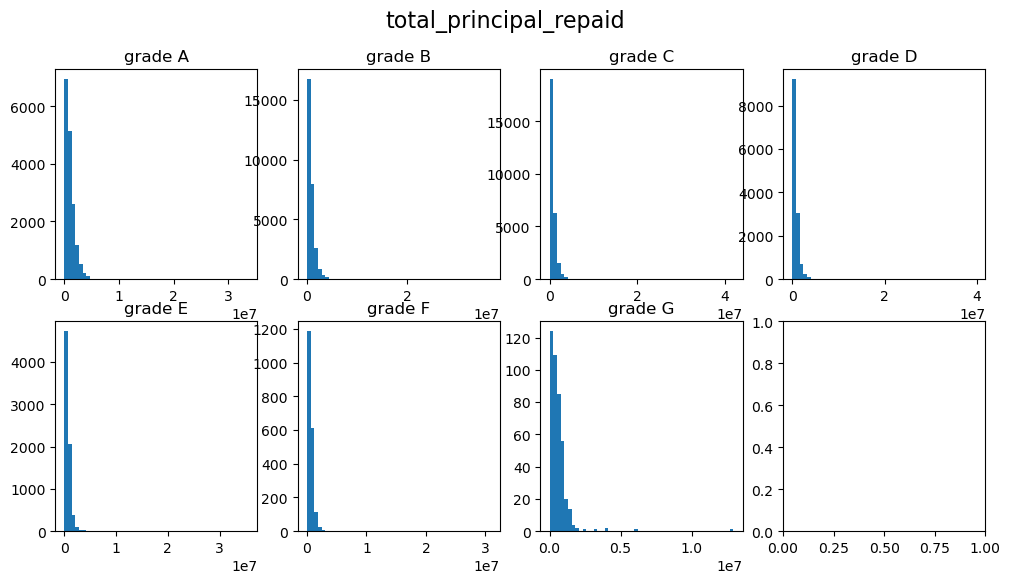

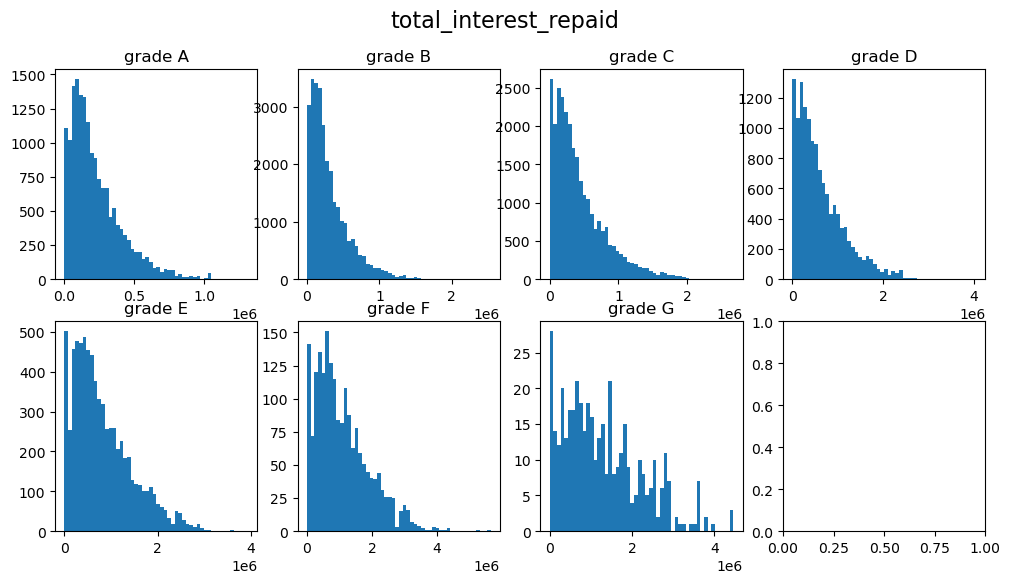

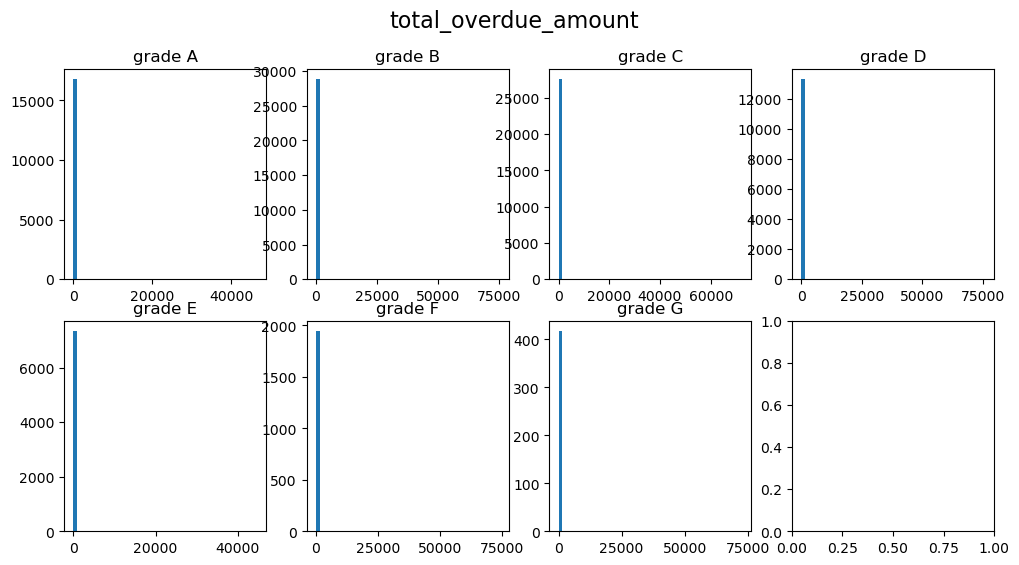

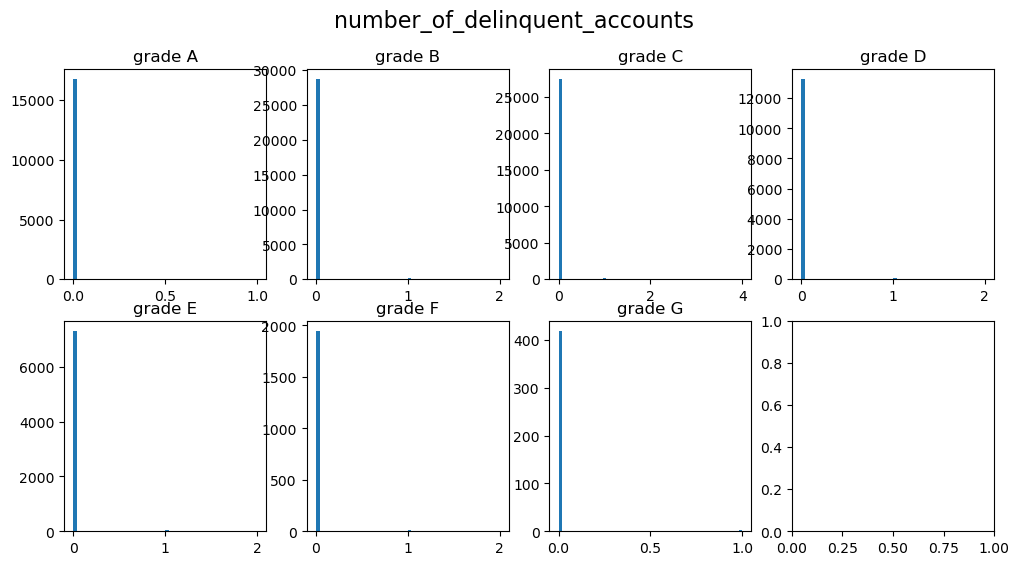

In [274]:
import seaborn as sns
from tqdm import tqdm
target = ['A','B','C','D','E','F','G']
    
def make_rpt(col):
    k = 0
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i in range(2):
        for j in range(4):
            if k >= len(target):
                continue
            ax = axes[i, j]
            data = train[train['loan_grade'] == k][col]
            ax.hist(data,bins=50)
            ax.set_title(f'grade {target[k]}')
            k += 1
    plt.suptitle(col, fontsize=16)

for tar in test.columns:
    make_rpt(tar)
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


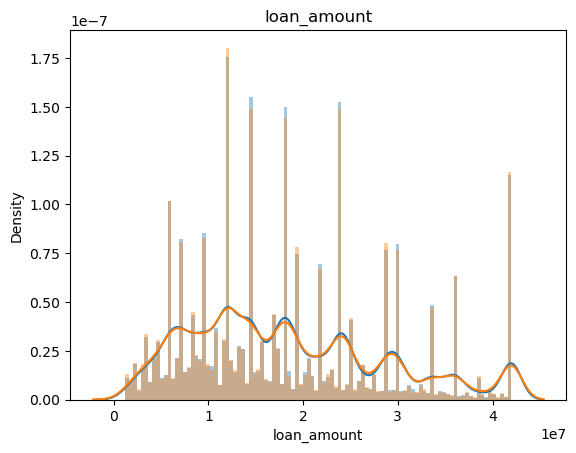

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


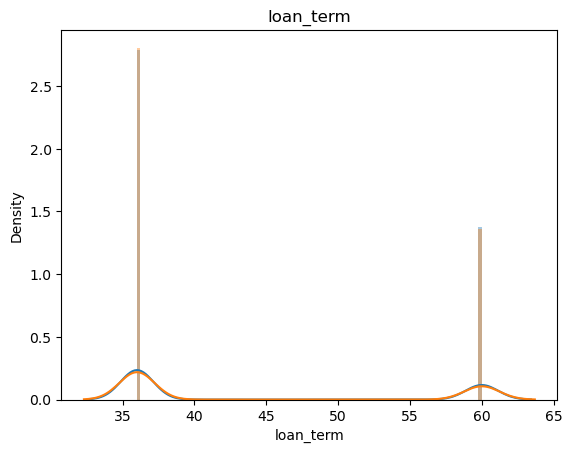

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


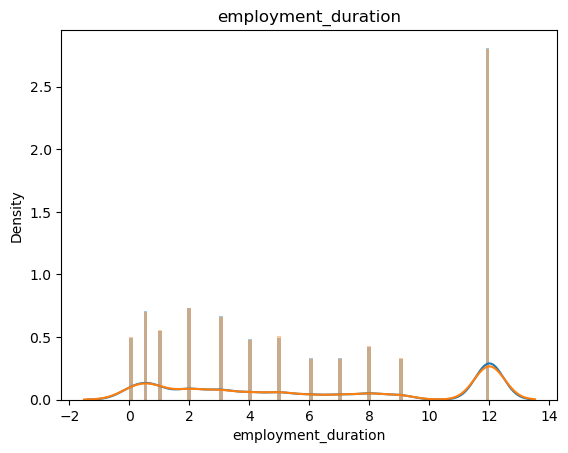

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


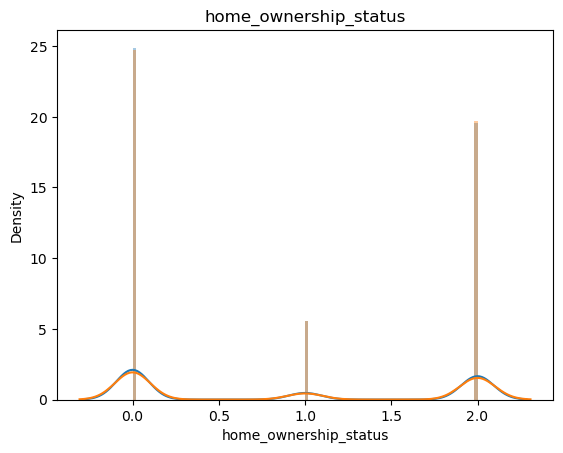

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


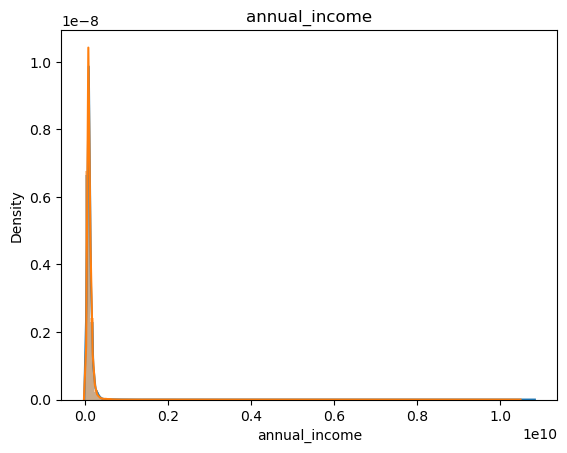

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


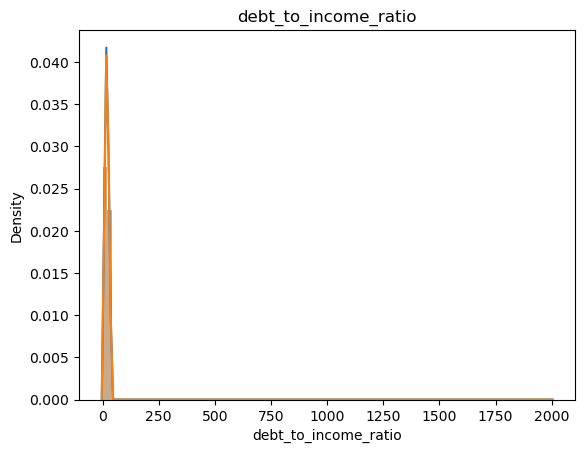

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


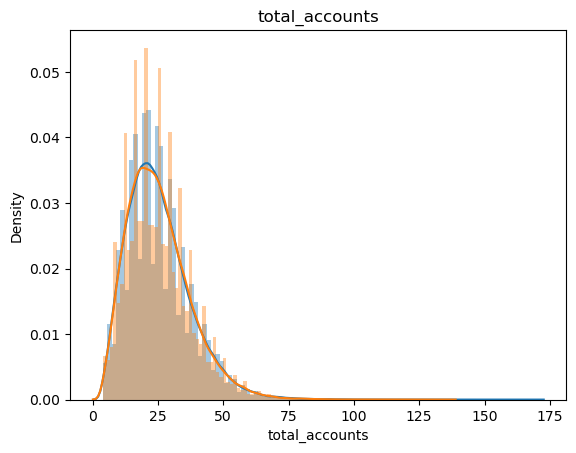

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


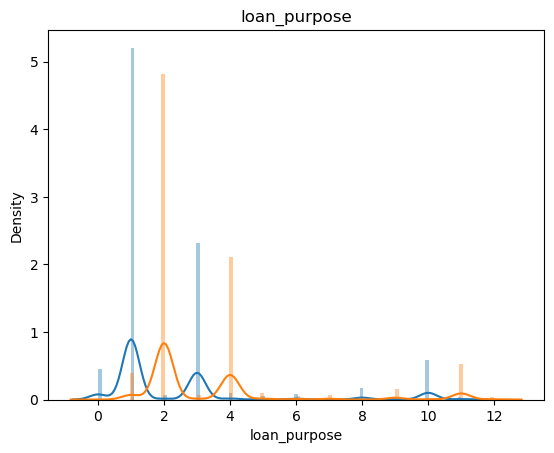

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


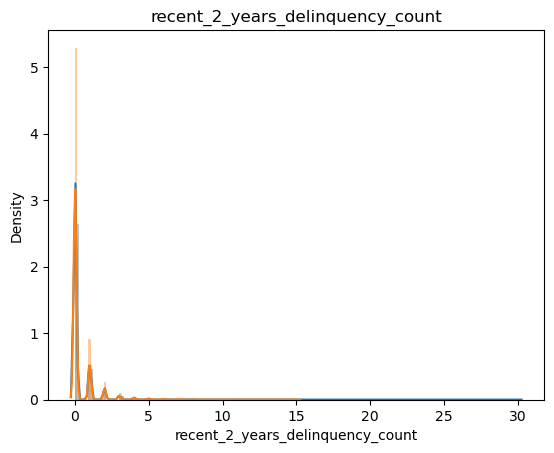

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


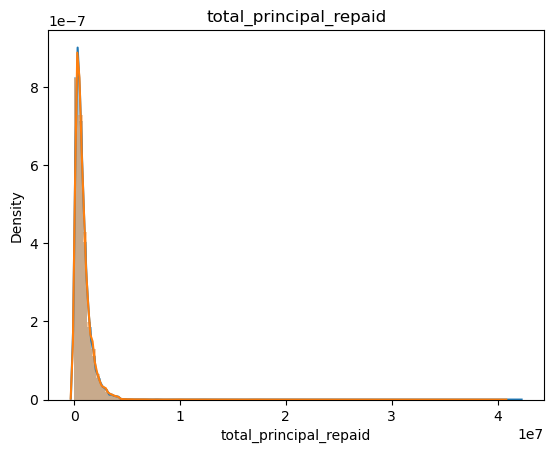

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


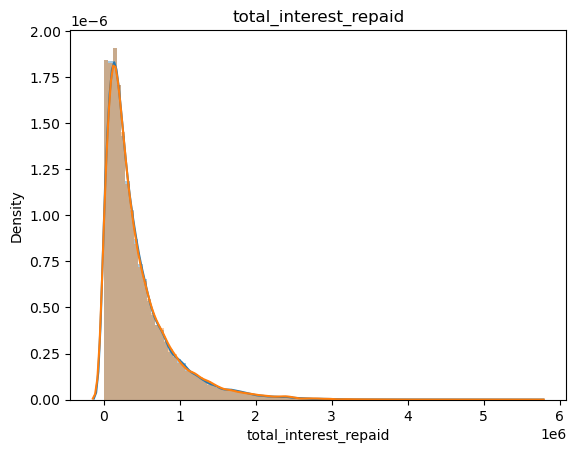

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


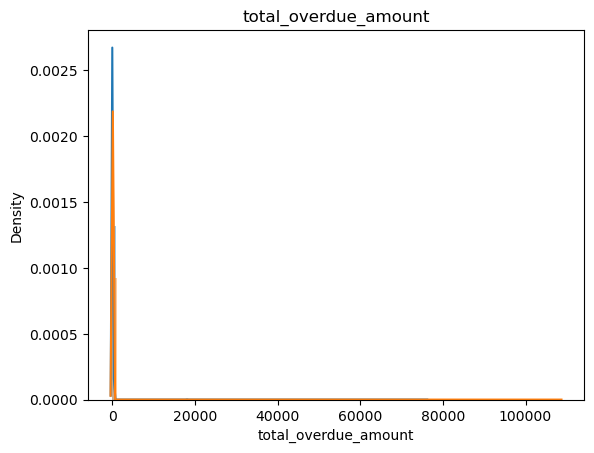

C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[tar],bins=100)
C:\Users\User\AppData\Local\Temp\ipykernel_8664\3187006465.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[tar],bins=100)


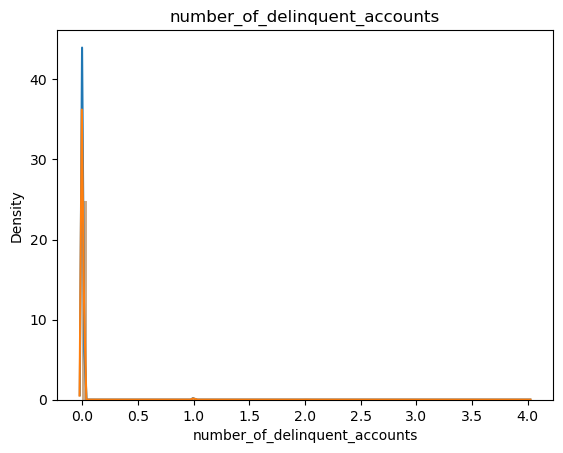

In [276]:
for tar in test.columns:
    sns.distplot(train[tar],bins=100)
    sns.distplot(test[tar],bins=100)
    plt.title(tar)
    plt.show()

C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


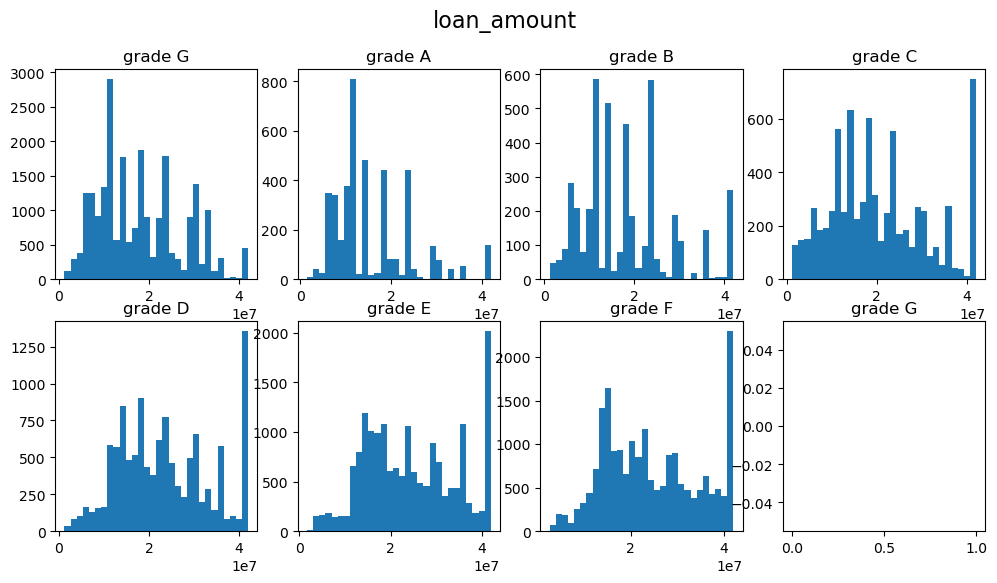

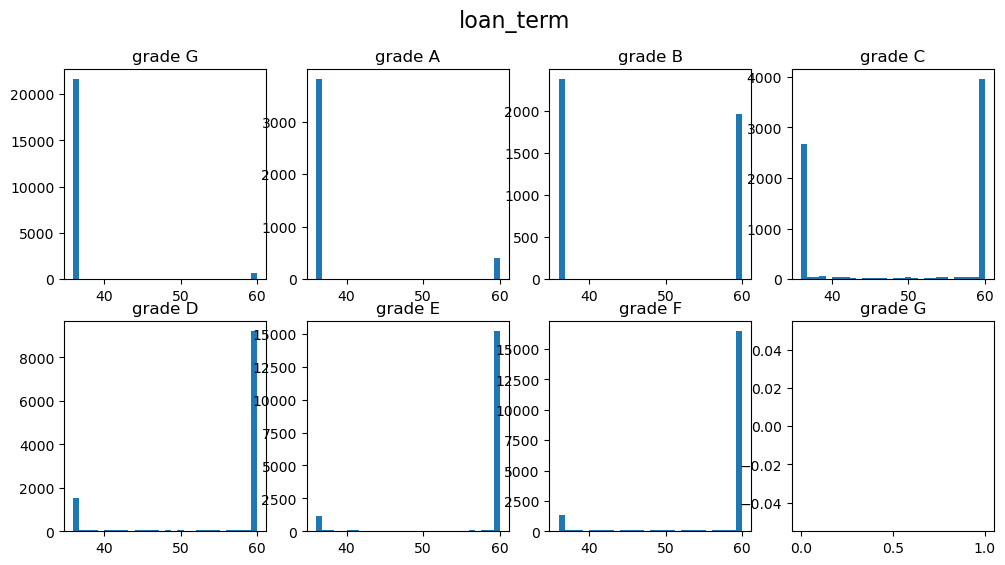

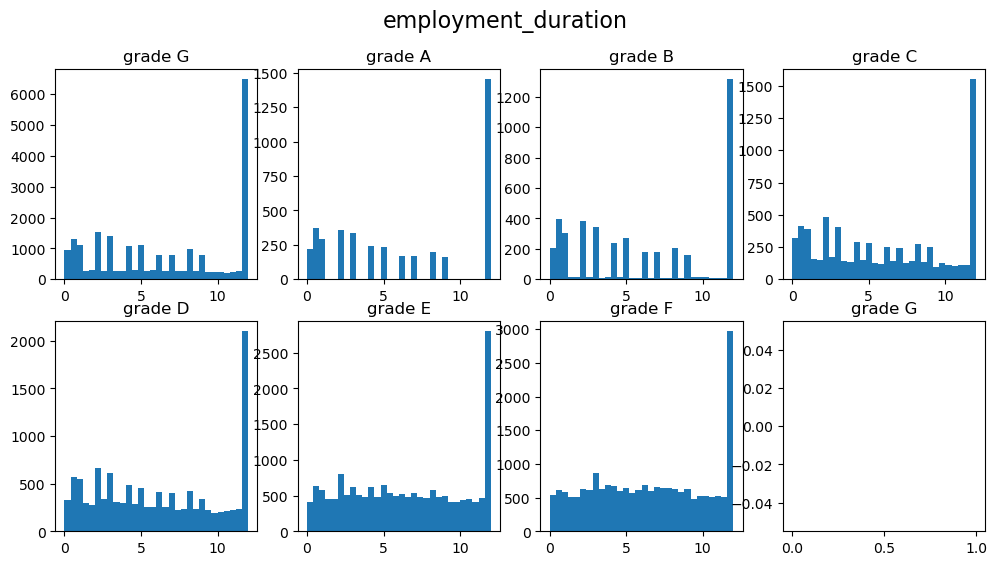

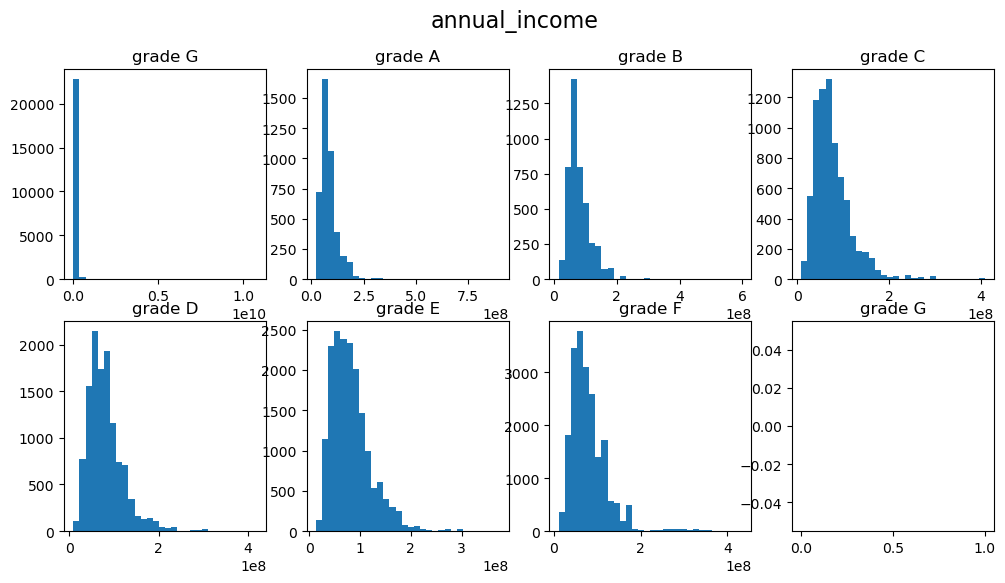

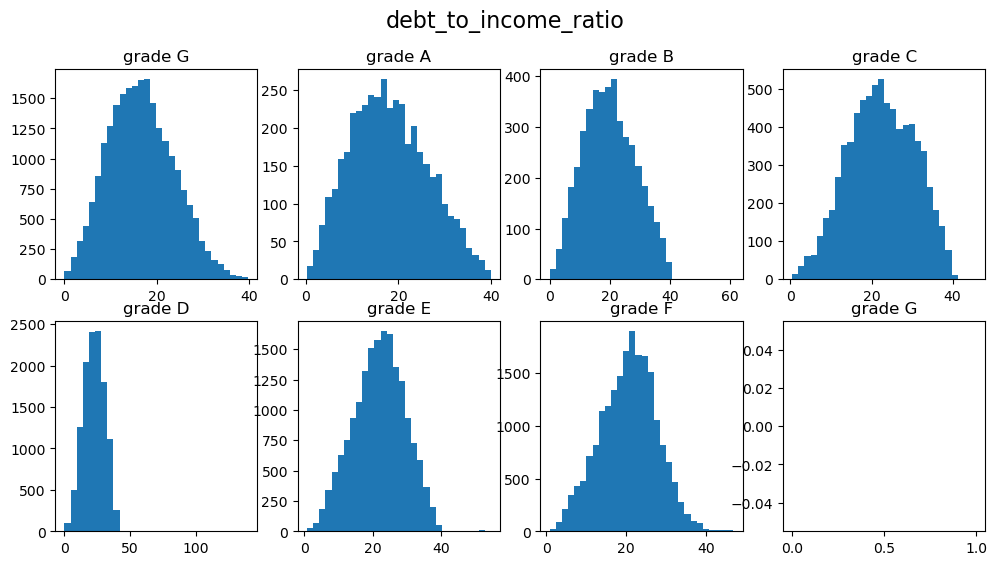

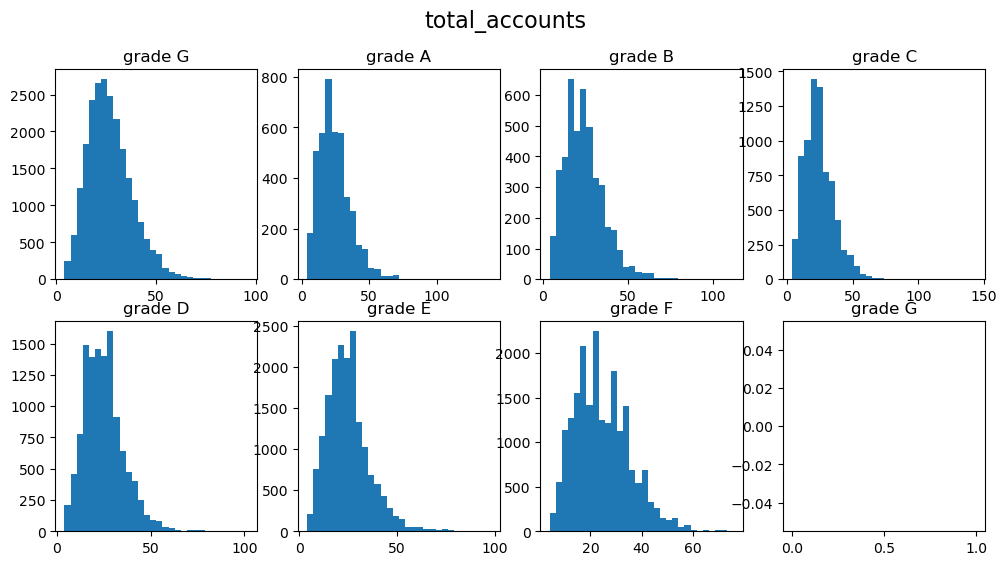

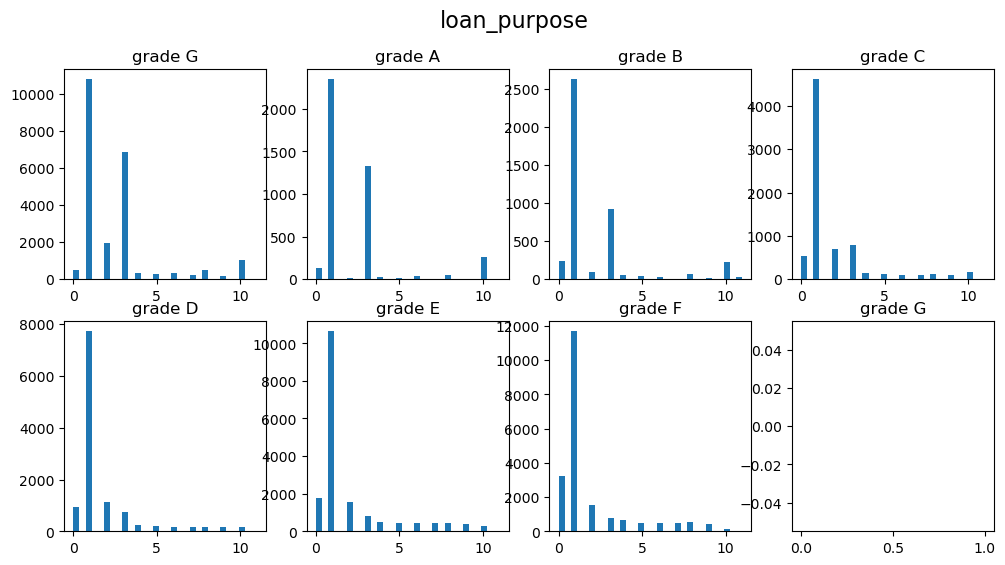

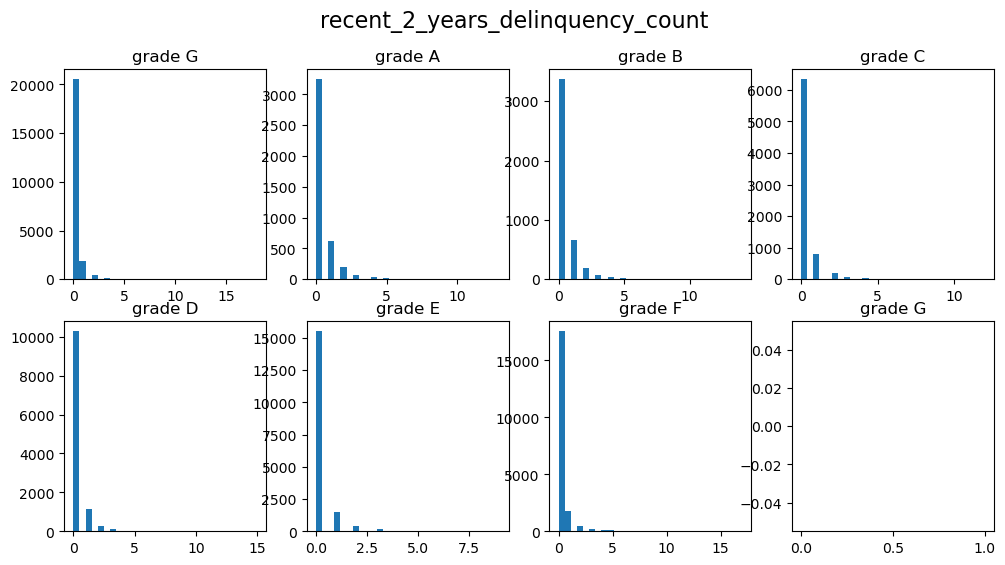

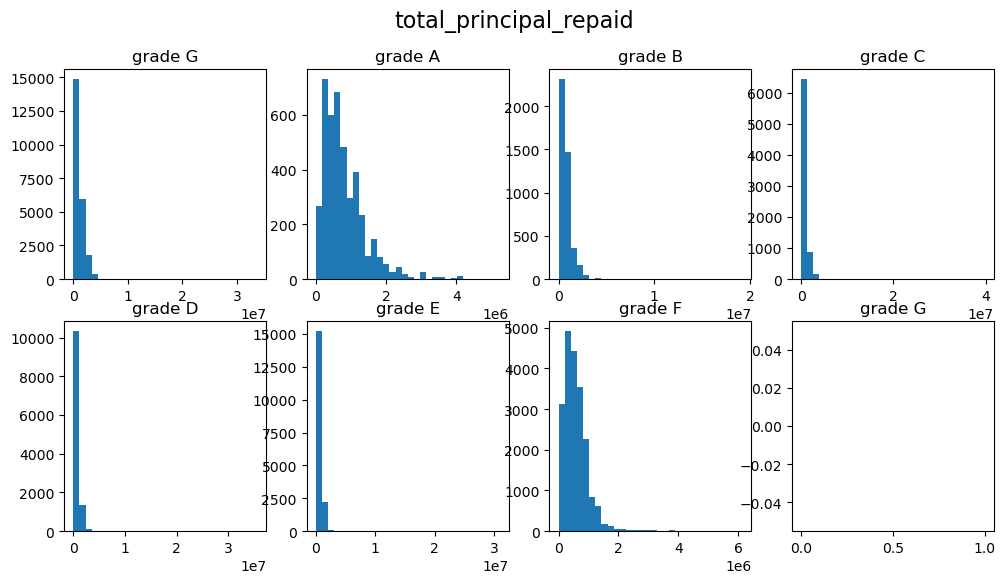

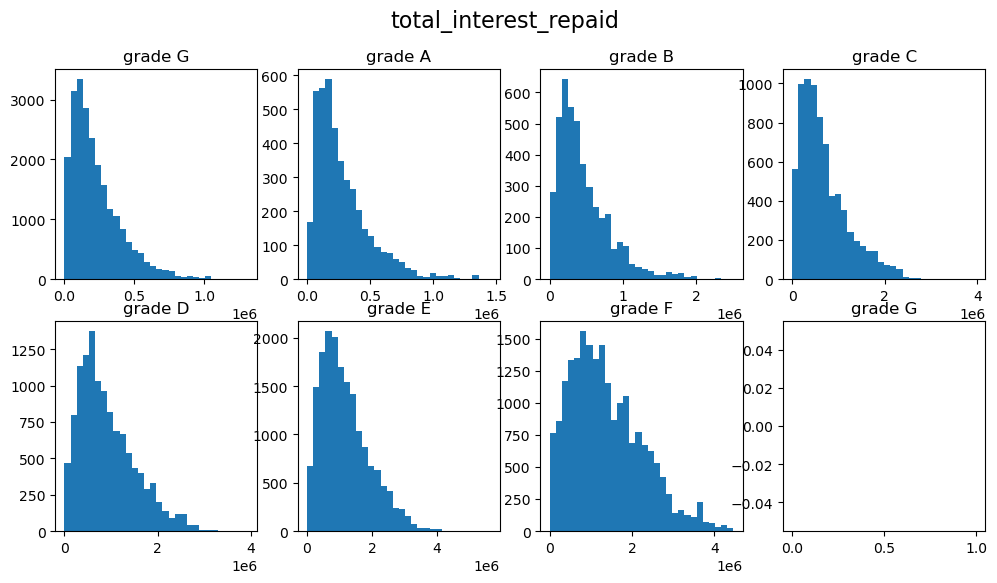

In [37]:
import seaborn as sns
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore

# # 각 피처에 대해 Z-Score 계산
# z_scores = np.abs(zscore(train))

# # Z-Score가 특정 임계값을 넘어가는 데이터 제거 (예: 3을 사용)
# train = train[(z_scores < 3).all(axis=1)]

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
target = 'loan_grade'
cut_ratio = 0.2

X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[[target]], test_size=0.2, stratify=train[[target]], random_state=42)

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 각 모델의 feature importance를 얻습니다.
lgbm_importance = lgbm.feature_importances_
xgb_importance = xgb.feature_importances_
catboost_importance = catboost.feature_importances_

# 각 모델의 feature importance를 합산합니다.
total_importance = lgbm_importance + xgb_importance + catboost_importance

# 중요도를 기준으로 상위 90%의 피쳐를 유지
threshold = np.percentile(total_importance, cut_ratio*100)
selected_features = X_train.columns[total_importance >= threshold]

# 유지된 피쳐를 기반으로 데이터를 업데이트
X_train = X_train[selected_features]
X_test = X_test[selected_features]
test = test[selected_features]

# 리샘플링 파이프라인 설정
resampling_pipeline = Pipeline([
    ('smote', SMOTE(random_state=1)),
    ('enn', EditedNearestNeighbours(n_neighbors=3))
])

# 리샘플링을 훈련 데이터에 적용
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train, y_train)
X_train = pd.concat([X_resampled,y_resampled],axis=1)

target = ['A','B','C','D','E','F','G']
    
def make_rpt(col):
    k = 0
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i in range(2):
        for j in range(4):
            try:
                if k > len(target):
                    continue
                ax = axes[i, j]
                data = X_train[X_train['loan_grade'] == k][col]
                ax.hist(data,bins=30)
                ax.set_title(f'grade {target[k]}')
                k += 1
            except:pass
    plt.suptitle(col, fontsize=16)

for tar in test.columns:
    make_rpt(tar)
    plt.show()

In [38]:
X_train['loan_grade'].value_counts()

0    23054
6    20375
5    17640
4    11908
3     7505
2     4379
1     4210
Name: loan_grade, dtype: int64

In [8]:
from pycaret.classification import *

# PyCaret에서 사용할 데이터 프레임 생성 (실제 데이터에 맞게 설정 필요)
# data = pd.concat([X_train, y_train], axis=1)

# PyCaret의 setup 함수를 사용하여 실험 환경 설정
exp1 = setup(X_train, target='loan_grade', fold=5, train_size=0.1, session_id=42)

# 모델 비교
best_model = compare_models(sort='F1', n_select=5) # , include=['lightgbm', 'xgboost', 'catboost'])

# best_model로 훈련
# final_model = finalize_model(best_model)

# 테스트 데이터에 대한 예측
# predictions = predict_model(final_model, data=X_test)

# # Macro F1 Score 출력
for md in best_model:
    predictions = predict_model(md, data=X_test)
    macro_f1_score = f1_score(y_test, predictions['prediction_label'], average='macro')
    print(f"Macro F1 Score on Test Data: {macro_f1_score:.4f}")

NameError: name 'X_train' is not defined

In [82]:
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import f1_score
# from sklearn.ensemble import VotingClassifier
# from sklearn.model_selection import train_test_split
# import numpy as np

# # 데이터를 훈련 세트와 테스트 세트로 나눕니다.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, stratify=y, random_state=42)

# # 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
# lgbm = LGBMClassifier(random_state=42)
# xgb = XGBClassifier(random_state=42)
# catboost = CatBoostClassifier(random_state=42, verbose=0)

# # 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
# lgbm.fit(X_train, y_train)
# xgb.fit(X_train, y_train)
# catboost.fit(X_train, y_train)

# # 각 모델의 feature importance를 얻습니다.
# lgbm_importance = lgbm.feature_importances_
# xgb_importance = xgb.feature_importances_
# catboost_importance = catboost.feature_importances_

# # 각 모델의 feature importance를 합산합니다.
# total_importance = lgbm_importance + xgb_importance + catboost_importance

# # 중요도를 기준으로 상위 90%의 피쳐를 유지
# threshold = np.percentile(total_importance, cut_ratio*100)
# selected_features = X_train.columns[total_importance >= threshold]

# # 유지된 피쳐를 기반으로 데이터를 업데이트
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# # 업데이트된 데이터로 모델 재훈련
# lgbm.fit(X_train_selected, y_train)
# xgb.fit(X_train_selected, y_train)
# catboost.fit(X_train_selected, y_train)

# # 테스트 데이터에 대한 예측
# lgbm_pred = lgbm.predict(X_test_selected)
# xgb_pred = xgb.predict(X_test_selected)
# catboost_pred = catboost.predict(X_test_selected)

# # 각 모델의 F1 score를 계산합니다.
# lgbm_f1 = f1_score(y_test, lgbm_pred, average='macro')
# xgb_f1 = f1_score(y_test, xgb_pred, average='macro')
# catboost_f1 = f1_score(y_test, catboost_pred, average='macro')

# print(f"LGBM Macro F1 Score: {lgbm_f1:.4f}")
# print(f"XGBoost Macro F1 Score: {xgb_f1:.4f}")
# print(f"CatBoost Macro F1 Score: {catboost_f1:.4f}")


In [9]:
def binary_data_processing():
    train = pd.read_csv('./open/train.csv')
    test = pd.read_csv('./open/test.csv')
    train['대출기간'] = train['대출기간'].apply(lambda x:x[:3])
    train['대출기간'] = train['대출기간'].astype('int64')
    test['대출기간'] = test['대출기간'].apply(lambda x:x[:3])
    test['대출기간'] = test['대출기간'].astype('int64')

    trans = {'1 year':1,
     '1 years':1,
     '10+ years':12,
     '10+years':12,
     '2 years':2,
     '3':3,
     '3 years':3,
     '4 years':4,
     '5 years':5,
     '6 years':6,
     '7 years':7,
     '8 years':8,
     '9 years':9,
     '< 1 year':0.5,
     '<1 year':0.5,
     'Unknown':0}

    train['근로기간'] = [trans[i] for i in train['근로기간'].values]
    test['근로기간'] = [trans[i] for i in test['근로기간'].values]
    train.loc[train[train['부채_대비_소득_비율'] == 9999].index,'부채_대비_소득_비율'] = 2000
    test.loc[test[test['부채_대비_소득_비율'] == 9999].index,'부채_대비_소득_비율'] = 2000
    train = train.drop(train[train['주택소유상태']=='ANY'].index)

    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()
    ordinal = OrdinalEncoder()

    for tt in ['주택소유상태','대출목적']:
        train[tt] = ordinal.fit_transform(train[[tt]])
        test[tt] = ordinal.fit_transform(test[[tt]])

    train = train.drop('ID',axis=1)
    test = test.drop('ID',axis=1)
    train = train.reset_index(drop=True)

    target = ['A','B','C','D','E','F','G']
    ordinal_mapping = {target[i]:0 for i in range(len(target))}
    ordinal_mapping['G'] = 1
    train['대출등급'] = train['대출등급'].map(ordinal_mapping)

    train.columns = ['loan_amount', 'loan_term', 'employment_duration', 'home_ownership_status', 
     'annual_income', 'debt_to_income_ratio', 'total_accounts', 'loan_purpose', 
     'recent_2_years_delinquency_count', 'total_principal_repaid', 'total_interest_repaid', 
     'total_overdue_amount', 'number_of_delinquent_accounts', 'loan_grade']
    test.columns = ['loan_amount', 'loan_term', 'employment_duration', 'home_ownership_status', 
     'annual_income', 'debt_to_income_ratio', 'total_accounts', 'loan_purpose', 
     'recent_2_years_delinquency_count', 'total_principal_repaid', 'total_interest_repaid', 
     'total_overdue_amount', 'number_of_delinquent_accounts']

    train = train.drop(['loan_purpose'],axis=1)
    test = test.drop(['loan_purpose'],axis=1)
    return train, test

In [284]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tqdm import tqdm
from scipy.stats import zscore
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.ensemble import IsolationForest


train,test = binary_data_processing()

# # 각 피처에 대해 Z-Score 계산
# z_scores = zscore(train)

# # Z-Score가 특정 임계값을 넘어가는 데이터 제거 (예: 3을 사용)
# train = train[(z_scores < 3).all(axis=1)]

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
target = 'loan_grade'
cut_ratio = 0.3
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[[target]], test_size=test_size, stratify=train[[target]], random_state=42)

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 각 모델의 feature importance를 얻습니다.
lgbm_importance = lgbm.feature_importances_
xgb_importance = xgb.feature_importances_
catboost_importance = catboost.feature_importances_

# 각 모델의 feature importance를 합산합니다.
total_importance = lgbm_importance + xgb_importance + catboost_importance

# 중요도를 기준으로 상위 90%의 피쳐를 유지
threshold = np.percentile(total_importance, cut_ratio*100)
selected_features = X_train.columns[total_importance >= threshold]

# 유지된 피쳐를 기반으로 데이터를 업데이트
X_train = X_train[selected_features]
X_test = X_test[selected_features]
test = test[selected_features]

# 리샘플링 파이프라인 설정
resampling_pipeline = Pipeline([
#    ('smote', SMOTE(random_state=1)),
    ('enn', EditedNearestNeighbours(n_neighbors=3))
])

# 리샘플링을 훈련 데이터에 적용
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train, y_train)
X_train = pd.concat([X_resampled,y_resampled],axis=1)
y_train = X_train[['loan_grade']]
X_train = X_train.drop('loan_grade',axis=1)

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
# lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, learning_rate=0.1, max_depth=8, n_estimators=100)
catboost = CatBoostClassifier(random_state=42, max_depth=8, verbose=0)
rf = RandomForestClassifier(random_state=42, oob_score=True)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
# lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 소프트 보팅 앙상블 모델 생성
ensemble_model = VotingClassifier(estimators=[
#    ('lgbm', lgbm),
    ('xgb', xgb),
    ('catboost', catboost),
#    ('rf', rf)
], voting='soft')

# Cross validation을 위한 StratifiedKFold 사용
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=4)

# f1_score를 평가 지표로 사용
scorer = make_scorer(f1_score, average='macro')

# 각 모델과 앙상블 모델에 대해 cross validation 수행
lgbm_cv_scores = cross_val_score(lgbm, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
xgb_cv_scores = cross_val_score(xgb, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
catboost_cv_scores = cross_val_score(catboost, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
# rf_cv_scores = cross_val_score(rf, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
ensemble_cv_scores = cross_val_score(ensemble_model, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)

# 결과 출력
# print(f"LGBM Cross Validation Macro F1 Scores: {np.mean(lgbm_cv_scores)}")
print(f"XGBoost Cross Validation Macro F1 Scores: {np.mean(xgb_cv_scores)}")
print(f"CatBoost Cross Validation Macro F1 Scores: {np.mean(catboost_cv_scores)}")
# print(f"RamdomForest Cross Validation Macro F1 Scores: {np.mean(rf_cv_scores)}")
print(f"Ensemble Model Cross Validation Macro F1 Scores: {np.mean(ensemble_cv_scores)}")


C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


XGBoost Cross Validation Macro F1 Scores: 0.7925949990428858
CatBoost Cross Validation Macro F1 Scores: 0.7472137962064629
Ensemble Model Cross Validation Macro F1 Scores: 0.7523766325834964


In [289]:
y_test['loan_grade'].value_counts()[1]

84

113
108
107
106
104
104
103
101
101
99
98
97
95
94
91
90
89
86
84
84
84
84
83
82
82
82
81
81
81
80
80
79
78
77
76
75
75
75
75
75
75
74
74
73
73
72
72
72
72
71


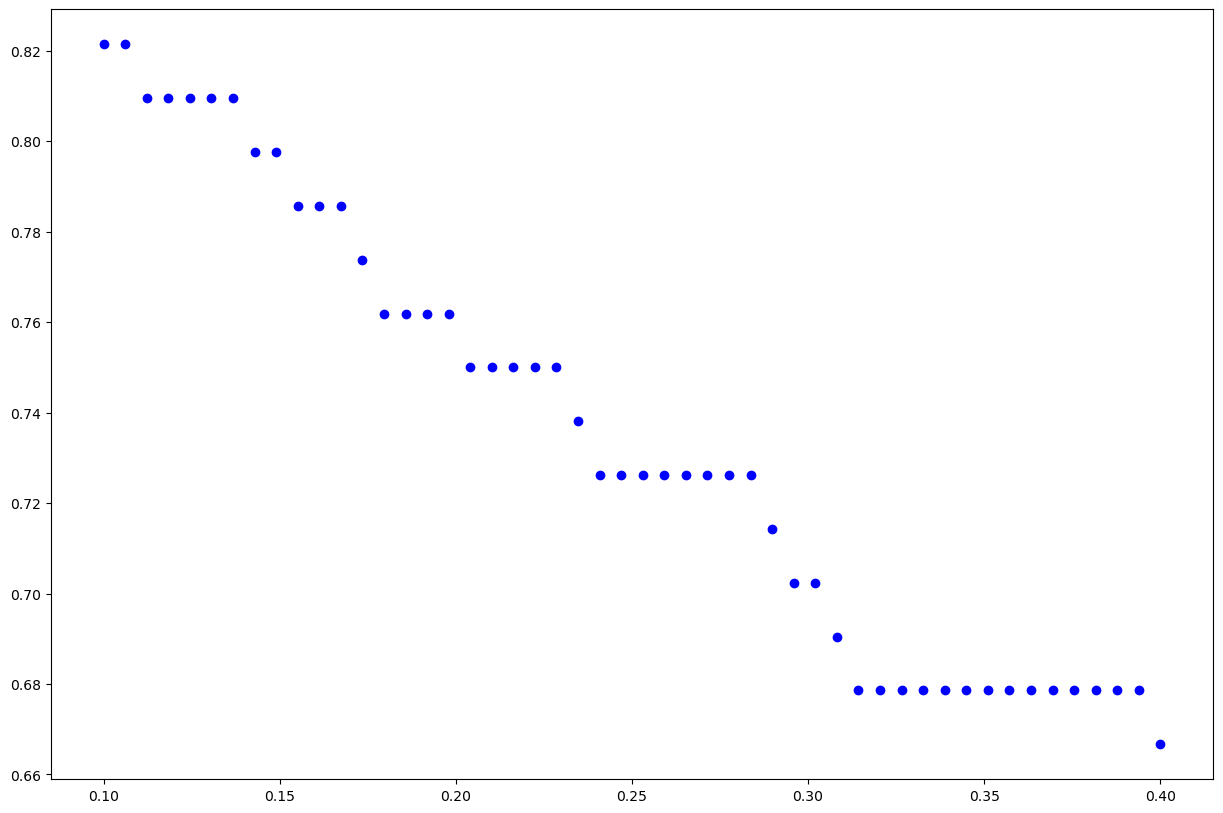

In [292]:
tp = y_test
divisor = y_test['loan_grade'].value_counts()[1]
plt.figure(figsize=(15,10))
for j in np.linspace(0.1,0.4,50):
    prediction = xgb.predict_proba(X_test)
    answer = []
    for i in prediction:
        if i[1] < j:
            answer.append(0)
        else:
            answer.append(1)
    tp['pred'] = answer
    val = (len(tp[(tp['pred'] == 1) & (tp['loan_grade'] == 1)])/divisor)
    plt.scatter(j,val,c='blue')
    print(sum(answer))

In [300]:
prediction = xgb.predict_proba(X_test)
answer = []
for i in prediction:
    if i[1] < 0.14:
        answer.append(0)
    else:
        answer.append(1)
tp['pred'] = answer
print(len(tp[(tp['pred'] == 1) & (tp['loan_grade'] == 1)])/divisor)

f1_score(tp['loan_grade'], tp['pred'], average='macro')


0.8095238095238095


0.8649392012513197

In [304]:
replace_grade_idx = tp[tp['pred'] == 1].index

In [11]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tqdm import tqdm
from scipy.stats import zscore
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.ensemble import IsolationForest

train, test = basic_data_processing()

# train = train.drop(train[train['loan_grade'] == 6].index)



# # 각 피처에 대해 Z-Score 계산
# z_scores = zscore(train)

# # Z-Score가 특정 임계값을 넘어가는 데이터 제거 (예: 3을 사용)
# train = train[(z_scores < 3).all(axis=1)]

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
target = 'loan_grade'
cut_ratio = 0.1
test_size = 0.1

# X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[[target]], test_size=test_size, stratify=train[[target]], random_state=42)
# tp['loan_grade'] = y_test

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 각 모델의 feature importance를 얻습니다.
lgbm_importance = lgbm.feature_importances_
xgb_importance = xgb.feature_importances_
catboost_importance = catboost.feature_importances_

# 각 모델의 feature importance를 합산합니다.
total_importance = lgbm_importance + xgb_importance + catboost_importance
total_importance = xgb_importance

# 중요도를 기준으로 상위 90%의 피쳐를 유지
threshold = np.percentile(total_importance, cut_ratio*100)
selected_features = X_train.columns[total_importance >= threshold]

# 유지된 피쳐를 기반으로 데이터를 업데이트
X_train = X_train[selected_features]
X_test = X_test[selected_features]
test = test[selected_features]

# 리샘플링 파이프라인 설정
resampling_pipeline = Pipeline([
#    ('smote', SMOTE(random_state=1)),
    ('enn', EditedNearestNeighbours(n_neighbors=3))
])

# # 리샘플링을 훈련 데이터에 적용
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_train, y_train)
X_train = pd.concat([X_resampled,y_resampled],axis=1)
y_train = X_train[['loan_grade']]
X_train = X_train.drop('loan_grade',axis=1)

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42, max_depth=8)
xgb = XGBClassifier(random_state=42, learning_rate=0.1, max_depth=8, n_estimators=100)
# catboost = CatBoostClassifier(random_state=42, max_depth=8, verbose=0)
# rf = RandomForestClassifier(random_state=42, oob_score=True)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
# catboost.fit(X_train, y_train)

# 소프트 보팅 앙상블 모델 생성
ensemble_model = VotingClassifier(estimators=[
   ('lgbm', lgbm),
    ('xgb', xgb),
#     ('catboost', catboost),
#    ('rf', rf)
], voting='soft')

# Cross validation을 위한 StratifiedKFold 사용
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# f1_score를 평가 지표로 사용
scorer = make_scorer(f1_score, average='macro')

# 각 모델과 앙상블 모델에 대해 cross validation 수행
lgbm_cv_scores = cross_val_score(lgbm, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
xgb_cv_scores = cross_val_score(xgb, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
# catboost_cv_scores = cross_val_score(catboost, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
# rf_cv_scores = cross_val_score(rf, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
ensemble_cv_scores = cross_val_score(ensemble_model, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)

# 결과 출력
print(f"LGBM Cross Validation Macro F1 Scores: {np.mean(lgbm_cv_scores)}")
print(f"XGBoost Cross Validation Macro F1 Scores: {np.mean(xgb_cv_scores)}")
# print(f"CatBoost Cross Validation Macro F1 Scores: {np.mean(catboost_cv_scores)}")
# print(f"RamdomForest Cross Validation Macro F1 Scores: {np.mean(rf_cv_scores)}")
print(f"Ensemble Model Cross Validation Macro F1 Scores: {np.mean(ensemble_cv_scores)}")


NameError: name 'resampling_pipeline' is not defined

In [ ]:
# tp['pred_6'] = ensemble_model.predict(X_test)
# tp

In [15]:
sub = pd.read_csv('./open/sample_submission.csv')
sub['대출등급'] = xgb.predict(test)
target = ['A','B','C','D','E','F','G']
ordinal_mapping = {i:target[i] for i in range(len(target))}
sub['대출등급'] = sub['대출등급'].map(ordinal_mapping)
sub = sub.set_index('ID')
sub.to_csv('./xgb.csv')

In [16]:
sub['대출등급'].value_counts()

A    64008
B      189
Name: 대출등급, dtype: int64